In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

sys.path.append("../src")
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

from visualization.cluster import plot_dendrogram
from visualization.training import plot_multiclass_roc_curve

In [2]:
iris = load_iris()
X,Y = iris.data, iris.target
df_iris = pd.DataFrame(X, columns=iris.feature_names)
df_iris['target'] = Y
print(df_iris.shape)
df_iris.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


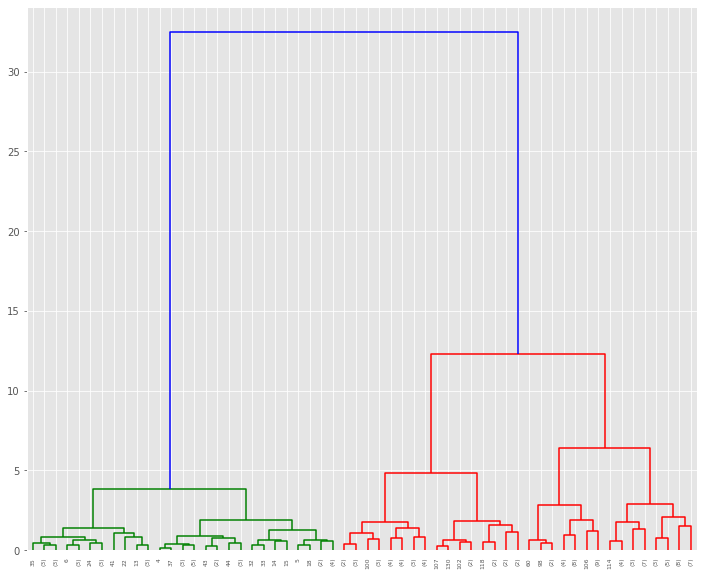

In [3]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',
                                memory='agglo_mem', distance_threshold=0)
model.fit(X)

plt.figure(figsize=(12,10))
plot_dendrogram(model, truncate_mode='level', p=5)

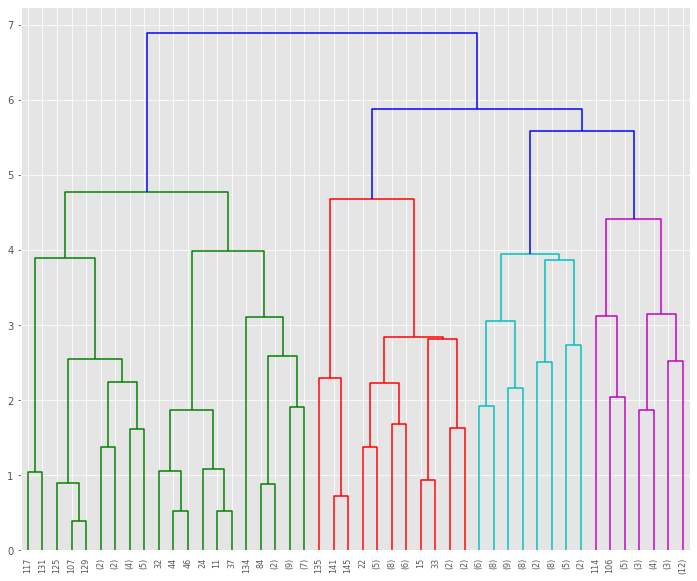

In [59]:
linked = linkage(X, method='complete', metric='mahalanobis')
fig = plt.figure(figsize=(12,10))
R = dendrogram(linked, orientation='top',
               distance_sort='descending', show_leaf_counts=True,
               truncate_mode='level', p=5)

## OPTICS

[Demo of OPTICS clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py)

## Cluster interpretation

[How to Understand your Clustering Results](https://towardsdatascience.com/understanding-clustering-cf0117148ef4)

In [4]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

In [5]:
clust = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward', memory='agglo_mem')
labels = clust.fit_predict(X)
df_iris['clust_labels'] = labels
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,clust_labels
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1


In [6]:
ohe = OneHotEncoder().fit(df_iris["clust_labels"].values.reshape((-1,1)))
clust_labels = ohe.transform(df_iris["clust_labels"].values.reshape((-1,1))).toarray()
est_clust = ohe.transform(df_iris["est_clust"].values.reshape((-1,1))).toarray()
print(clust_labels.shape)
display(clust_labels[:10])
print(est_clust.shape)
display(est_clust[:10])

KeyError: 'est_clust'

In [30]:
from sklearn.metrics import roc_curve

In [32]:
fpr, tpr, _ = roc_curve(clust_labels[:, 0], est_clust[:, 0])

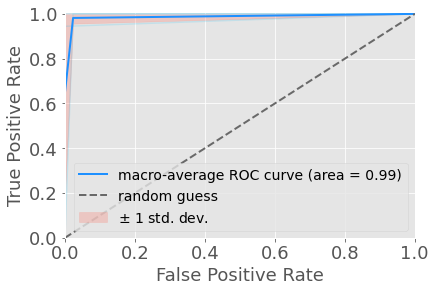

In [11]:
est_clust = RandomForestClassifier(max_depth=2)
est_clust.fit(df_iris.loc[:,"sepal length (cm)":"petal width (cm)"],
              df_iris.loc[:,"clust_labels"])
df_iris["est_clust"] = est_clust.predict(df_iris.loc[:,"sepal length (cm)":"petal width (cm)"])

ohe = OneHotEncoder().fit(df_iris["clust_labels"].values.reshape((-1,1)))

plot_multiclass_roc_curve(ohe.transform(df_iris["clust_labels"].values.reshape(-1,1)).toarray(),
                          ohe.transform(df_iris["est_clust"].values.reshape(-1,1)).toarray())

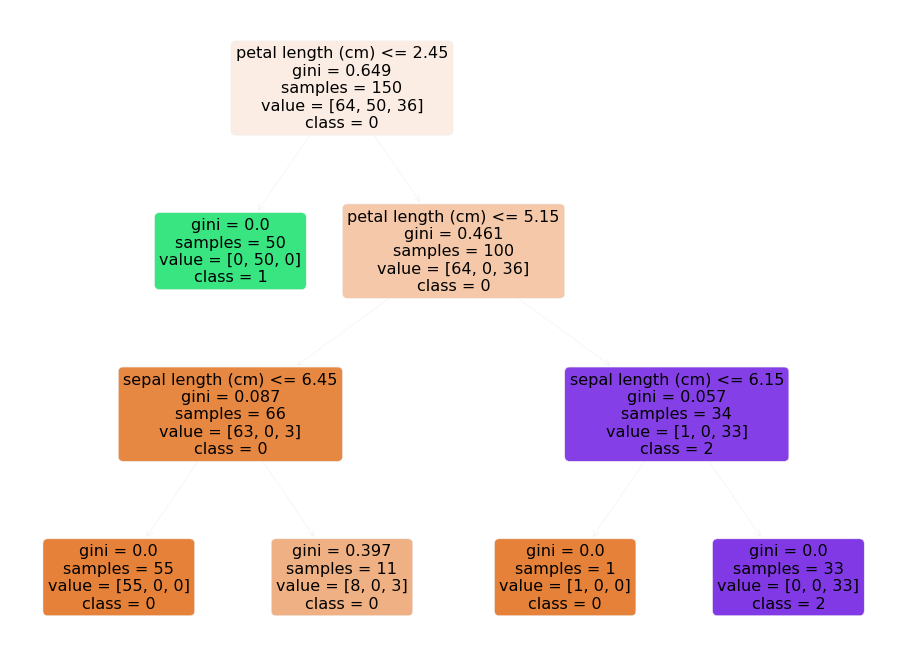

In [86]:
est = DecisionTreeClassifier(max_depth=3)
est.fit(X.iloc[:,:-1], X.iloc[:,-1])

# Must have graphviz installed
# dot_data = export_graphviz(est, out_file=None,
#                            feature_names=list(X.iloc[:,:-1].columns),
#                            filled=True, rounded=True,
#                            special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph
class_names = list(map(str,sorted(X['clust_labels'].unique())))
plt.figure(figsize=(16,12))
annot = plot_tree(est, feature_names=list(X.iloc[:,:-1].columns),
                  class_names=class_names,
                  filled=True, rounded=True)